### Linear Regresion Test Project

#### For this project we will use the Housing Data for the city of Ames, Iowa in United States from 2006 to 2010. 
#### The intention is to use the relevant columns do create a linear regresion model that let us predict the values for the Sales Price.
#### We will make some validations to get the RMSE (Root Mean Square Error), and use it to have an idea of how good or bad is the model we made.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("AmesHousing.tsv", sep="\t")

In [3]:
# This function will make some changes to prepare the dataset.
# Changes like delete text columns with missing values,
# numeric columns with 5% or less missing values get their missing values replaced
# with the mode of that column, create a new column to show the amount of year 
# until events like remodelation, and drop some other columns that are not useful.
def transform_features(data):
    percent_5 = round(len(data) * 0.05)
    percent_95 = round(len(data) * 0.95)
    #print(percent_95)
    data_edited = data.dropna(thresh=percent_95, axis=1).copy()
    
    #Drop text columns with missing values
    text_counts = data_edited.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_cols = text_counts[text_counts > 0]
    data_edited = data_edited.drop(drop_cols.index, axis=1)

    #Replace values of numeric columns with 5% or less missing value
    numeric_cols = data_edited.select_dtypes(include=["int", "float"]).columns
    null_counts = data_edited[numeric_cols].isnull().sum()
    less_than_5_percent_numeric = null_counts[(null_counts > 0) & (null_counts < percent_5)].index
    #print(data_edited[less_than_5_percent_numeric].isnull().sum())
    replacement_values_dict = data_edited[less_than_5_percent_numeric].mode().to_dict(orient='records')[0]
    #print(replacement_values_dict)
    data_edited = data_edited.fillna(replacement_values_dict)
    #print(data_edited[less_than_5_percent_numeric].isnull().sum())
    
    data_edited["years_until_sold"] = data_edited['Yr Sold'] - data_edited['Year Built']
    data_edited["years_until_remod"] = data_edited['Yr Sold'] - data_edited['Year Remod/Add']
    #print(data_edited[data_edited["years_until_sold"] < 0])
    #print(data_edited[data_edited["years_until_remod"] < 0])
    data_edited = data_edited.drop([1702, 2180, 2181], axis=0)
    
    #Columns "Order" and "PID" are not useful for the machine learning model
    data_edited = data_edited.drop(["Order", "PID"], axis=1)
    #Some other columns leak data about the sales (that will be our target column)
    data_edited = data_edited.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold", "Year Built", "Year Remod/Add"], axis=1)
    
    return data_edited

In [4]:
def select_features(data_edited, corr_value=0.4, min_unique=2, max_unique=10):
    numeric_cols = data_edited.select_dtypes(include=["int", "float"]).columns
    sorted_corr = data_edited[numeric_cols].corr()["SalePrice"].abs().sort_values()
    #Drop columns with less than the corr_value with SalePrice
    data_edited = data_edited.drop(sorted_corr[sorted_corr < corr_value].index, axis=1)
    
    #Following documentation, these features are meant to be categorical
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
  
    #Comparison of the categorical columns in documentation, and the ones we will
    #still be using.
    categ_cols = []
    for col in nominal_features:
        if col in data_edited.columns:
            categ_cols.append(col)

    #Amount of unique values per column (feature)
    unique_count = data_edited[categ_cols].apply(lambda col: len(col.value_counts())).sort_values()
   
    #Here we can try different setups for the amount of unique values as maximum.
    #Lets use 2 as the min and 10 as the max amount for now, 
    #but it can be changed later as experiment.
    too_many_unique = unique_count[(unique_count < min_unique) | (unique_count > max_unique)].index
    data_edited = data_edited.drop(too_many_unique, axis=1)
 
    #Convert remaining text columns to category
    text_cols = data_edited.select_dtypes(include=['object'])
    for col in text_cols:
        data_edited[col] = data_edited[col].astype('category')    
 
    #Create dummy columns and add back to the dataframe, and delete text cols.
    data_edited = pd.concat([data_edited, 
                             pd.get_dummies(data_edited.select_dtypes(include=['category']))
                            ], axis=1).drop(text_cols,axis=1)

    return data_edited

In [5]:
# This function will divide the dataset for the test and train sets.
# It will also train the model and make predictions, as well as verify the
# performance of the model.
def train_and_test(data_edited, fold_num=0):
    train_cols = data_edited.columns
    train_cols = train_cols[train_cols != "SalePrice"]
    #Alternative: (Categorical data is detected as numeric using select_dtypes)
#     numeric_data_edited = data_edited.select_dtypes(include=['integer', 'float'])
#     train_cols = numeric_data_edited.columns.drop("SalePrice")
    lr = LinearRegression()
    
    if fold_num == 0:
        #Use the basic train and test set without Cross Validation
        train = data_edited.iloc[:1460]
        test = data_edited.iloc[1460:]
        lr.fit(train[train_cols], train["SalePrice"])
        predictions = lr.predict(test[train_cols])
        rmse = np.sqrt(mean_squared_error(test["SalePrice"], predictions))
        return rmse
    
    if fold_num == 1:
        #Use simple Cross Validation
        data_edited = data_edited.sample(frac=1)
        fold_1 = data_edited.iloc[:1460]
        fold_2 = data_edited.iloc[1460:]
        lr = LinearRegression()
        lr.fit(fold_1[train_cols], fold_1["SalePrice"])
        predictions_1 = lr.predict(fold_2[train_cols])
        rmse_1 = np.sqrt(mean_squared_error(fold_2["SalePrice"], predictions_1))
        #print(rmse_1)
        
        lr.fit(fold_2[train_cols], fold_2["SalePrice"])
        predictions_2 = lr.predict(fold_1[train_cols])
        rmse_2 = np.sqrt(mean_squared_error(fold_1["SalePrice"], predictions_2))
        #print(rmse_2)
        
        rmse = np.mean([rmse_1, rmse_2])
        return rmse
    
    else:
        #Use Cross Validation with values of 3 or higher for K
        kf = KFold(n_splits=fold_num, shuffle=True)   
        mses = cross_val_score(estimator=lr, X=data_edited[train_cols], y=data_edited["SalePrice"], scoring="neg_mean_squared_error", cv=fold_num)
        rmse = (abs(mses)**(1/2)).mean()
        
        #Alternative version:
#         kf = KFold(n_splits=k, shuffle=True)
#         rmse_values = []
#         for train_index, test_index, in kf.split(data_edited):
#             train = data_edited.iloc[train_index]
#             test = data_edited.iloc[test_index]
#             lr.fit(train[train_cols], train["SalePrice"])
#             predictions = lr.predict(test[train_cols])
#             mse = mean_squared_error(test["SalePrice"], predictions)
#             rmse = np.sqrt(mse)
#             rmse_values.append(rmse)
#         print(rmse_values)
#         rmse = np.mean(rmse_values)
        
    return rmse

#### Here are a few tests and explorations that were made outside the functions but were added later.

In [6]:
data

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
5,6,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500
6,7,527127150,120,RL,41.0,4920,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,213500
7,8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191500
8,9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,236500
9,10,527162130,60,RL,60.0,7500,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,189000


In [7]:
data_edited_test = transform_features(data)
data_edited_test

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,years_until_sold,years_until_remod
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,210,62,0,0,0,0,0,215000,50,50
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,140,0,0,0,120,0,0,105000,49,49
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,393,36,0,0,0,0,12500,172000,52,52
3,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,0,0,0,0,0,244000,42,42
4,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,212,34,0,0,0,0,0,189900,13,12
5,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,360,36,0,0,0,0,0,195500,12,12
6,120,RL,4920,Pave,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,...,0,0,170,0,0,0,0,213500,9,9
7,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,...,0,82,0,0,144,0,0,191500,18,18
8,120,RL,5389,Pave,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,...,237,152,0,0,0,0,0,236500,15,14
9,60,RL,7500,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,...,140,60,0,0,0,0,0,189000,11,11


In [8]:
sorted_corr_test = data_edited_test.corr()["SalePrice"].abs().sort_values()
sorted_corr_test

BsmtFin SF 2         0.006127
Misc Val             0.019273
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
years_until_remod    0.534985
Full Bath            0.546118
years_until_sold     0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: Sale

In [9]:
strong_corr_test = sorted_corr_test[sorted_corr_test > 0.3]
strong_corr_test

Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
years_until_remod    0.534985
Full Bath            0.546118
years_until_sold     0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: SalePrice, dtype: float64

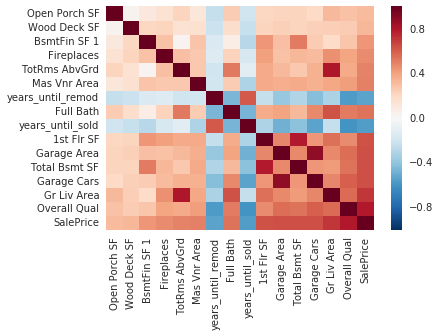

In [10]:
data_edited_strong_corr_test = data_edited_test[strong_corr_test.index].corr()
sns.heatmap(data_edited_strong_corr_test)
plt.show()

##### Here is a heatmap showing the correlation of all the columns with correlation of 0.3 or more with the SalePrice column (our target column for predictions).

In [11]:
#Following documentation, these features are meant to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

In [12]:
#Comparison of the categorical columns in documentation, and the ones we will
#still be using.
categ_cols_test = []
for col in nominal_features:
    if col in data_edited_test.columns:
        categ_cols_test.append(col)
display(categ_cols_test)

#Amount of unique values per column (feature)
unique_count_test = data_edited_test[categ_cols_test].apply(lambda col: len(col.value_counts())).sort_values()
print(unique_count_test)

#Here we can try different setups for the amount of unique values as maximum.
#Lets use 2 as the min and 10 as the max amount for now, 
#but it can be changed later as experiment.
too_many_unique_test = unique_count_test[(unique_count_test < 2) | (unique_count_test > 10)].index
data_edited_test = data_edited_test.drop(too_many_unique_test, axis=1)

['MS SubClass',
 'MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air']

Central Air      2
Street           2
Land Contour     4
Lot Config       5
Bldg Type        5
Heating          6
Roof Style       6
Foundation       6
MS Zoning        7
Condition 2      8
House Style      8
Roof Matl        8
Condition 1      9
Exterior 1st    16
MS SubClass     16
Exterior 2nd    17
Neighborhood    28
dtype: int64


In [13]:
#Convert remaining text columns to category
text_cols_test = data_edited_test.select_dtypes(include=['object'])
for col in text_cols_test:
    data_edited_test[col] = data_edited_test[col].astype('category')    
display(text_cols_test)

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Condition 1,Condition 2,Bldg Type,...,Roof Matl,Exter Qual,Exter Cond,Foundation,Heating,Heating QC,Central Air,Kitchen Qual,Functional,Paved Drive
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,...,CompShg,TA,TA,CBlock,GasA,Fa,Y,TA,Typ,P
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,Feedr,Norm,1Fam,...,CompShg,TA,TA,CBlock,GasA,TA,Y,TA,Typ,Y
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,...,CompShg,TA,TA,CBlock,GasA,TA,Y,Gd,Typ,Y
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,...,CompShg,Gd,TA,CBlock,GasA,Ex,Y,Ex,Typ,Y
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,CompShg,TA,TA,PConc,GasA,Gd,Y,TA,Typ,Y
5,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,CompShg,TA,TA,PConc,GasA,Ex,Y,Gd,Typ,Y
6,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,TwnhsE,...,CompShg,Gd,TA,PConc,GasA,Ex,Y,Gd,Typ,Y
7,RL,Pave,IR1,HLS,AllPub,Inside,Gtl,Norm,Norm,TwnhsE,...,CompShg,Gd,TA,PConc,GasA,Ex,Y,Gd,Typ,Y
8,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,TwnhsE,...,CompShg,Gd,TA,PConc,GasA,Ex,Y,Gd,Typ,Y
9,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,CompShg,TA,TA,PConc,GasA,Gd,Y,Gd,Typ,Y


In [14]:
#Create dummy columns and add back to the dataframe, and delete text cols.
data_edited_test = pd.concat([data_edited_test, 
                         pd.get_dummies(data_edited_test.select_dtypes(include=['category']))
                        ], axis=1).drop(text_cols_test,axis=1)

display(data_edited_test)

,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,...,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,0,...,0,0,0,0,0,0,1,0,1,0
1,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,0,...,0,0,0,0,0,0,1,0,0,1
2,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,0,...,0,0,0,0,0,0,1,0,0,1
3,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,0,...,0,0,0,0,0,0,1,0,0,1
4,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,701,...,0,0,0,0,0,0,1,0,0,1
5,9978,6,6,20.0,602.0,0.0,324.0,926.0,926,678,...,0,0,0,0,0,0,1,0,0,1
6,4920,8,5,0.0,616.0,0.0,722.0,1338.0,1338,0,...,0,0,0,0,0,0,1,0,0,1
7,5005,8,5,0.0,263.0,0.0,1017.0,1280.0,1280,0,...,0,0,0,0,0,0,1,0,0,1
8,5389,8,5,0.0,1180.0,0.0,415.0,1595.0,1616,0,...,0,0,0,0,0,0,1,0,0,1
9,7500,7,5,0.0,0.0,0.0,994.0,994.0,1028,776,...,0,0,0,0,0,0,1,0,0,1


#### Now that we made the proper changes to our functions, let's use them to transform, select, and train/test our data.

In [15]:
transformed_data = transform_features(data)
selected_data = select_features(transformed_data, 0.4, 2, 10)
results = train_and_test(selected_data, 4)
print("Average value for RMSE with the values provided: ", results)

Average value for RMSE with the values provided:  29220.914133085993


#### As we can see we were able to obtain a pretty good RMSE after selecting certains features/columns to train.
#### We could obtain different values depending on what columns we use and also in the K value for the KFold or the minimum correlation value we want.   So we could even design a better model to get better results.